In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import os

import random
import socket
from datetime import datetime

from pprint import PrettyPrinter

import torch
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
from tensorboardX import SummaryWriter

import numpy as np

### Project-specific loaders ###
from depthnet.model import make_model, split_params_weight_bias
from depthnet.data import load_depth_data, AddDepthHist
from depthnet.train_utils import make_training, train
from depthnet.model.wrapper import DepthNetWrapper
from depthnet.checkpoint import load_checkpoint, safe_makedir
from depthnet.model.loss import berhu, delta, rmse, rel_abs_diff, rel_sqr_diff
### end ###

def init_randomness(seed):
    cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def show(img):
    """Displays a 3-channel RGB image or a 1-channel Grayscale image.
    Input should have 3 dimensions, with the first being the number of channels
    (as is standard in pytorch).
    """
    plt.figure()
    npimg = img.cpu().numpy()
    if npimg.shape[0] == 1: # Single-channel image
        npimg = np.concatenate([npimg, npimg, npimg], axis=0)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def show_hist(hist, min_depth, max_depth):
    """Input should be a 1d numpy array with the value for each
    bin specified.
    
    In particular, this does NOT compute a histogram on hist before displaying: it assumes
    that bar-graphing hist is what will produce the histogram.
    """
    fig = plt.figure(figsize=(50, 20))
    ax = fig.add_subplot(111)
    ax.bar(np.linspace(min_depth, max_depth, len(hist)), hist, width=(max_depth - min_depth)/len(hist));

In [3]:
model_config = {
    "model_name": "UNet",                   # {DepthNet, DepthNetWithHints, UNet, UNetWithHints}
    "model_params": {
        "input_nc": 3,                      # Number of input channels
        "output_nc": 1,                     # Number of output channels
        "hist_len": 800//3,                 # Length of the histogram (hints only)
        "num_hints_layers": 4,              # Number of 1x1 conv layers for hints (hints only)
        "len_hints_layers": 512,            # Number of units in the hints conv layers.
        "upsampling": "bilinear",           # {bilinear, nearest}
    },
    "model_state_dict_fn": None,            # Function for getting the state dict
}

In [4]:
# Checkpoint for file
comment = ""
ckpt_config = {
    "ckpt_file": "checkpoints/Dec27_01-39-23_ares_rawhist/checkpoint_epoch_79.pth.tar",
    "ckpt_dir": "checkpoints",
    "run_id": datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname() + comment,
    "log_dir": "runs",
}

In [5]:
# Data Loading
root_dir = os.path.join("data", "nyu_depth_v2_processed")
train_file = os.path.join(root_dir, "train.json")
train_dir = root_dir
val_file = os.path.join(root_dir, "test.json")
val_dir = root_dir
test_file = None
test_dir = None
del root_dir

# Indices of images to exclude from the dataset.
blacklist_file = os.path.join("blacklist.txt")

batch_size = 20             # Number of training examples per iteration
train_keywords = None
val_keywords = None
test_keywords = None
depth_format = "NYU"
hist_use_albedo = False
hist_use_squared_falloff = False

min_depth = 1e-3
max_depth = 10.
# For testing how data loads. Turns off normalization.
test_loader = False

In [6]:
# Misc.
seed = 95290421
cuda_device = "0"                       # The gpu index to run on. Should be a string
test_run = False                        # Whether or not to truncate epochs for testing
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device
# print("after: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: {} (CUDA_VISIBLE_DEVICES = {})".format(device,
                                                            os.environ["CUDA_VISIBLE_DEVICES"]))
if ckpt_config["ckpt_file"] is not None:
    model_update, _, ckpt_update = load_checkpoint(ckpt_config["ckpt_file"], device)
    model_config.update(model_update)
    ckpt_config.update(ckpt_update)

    del model_update, _, ckpt_update
    
init_randomness(seed)

using device: cuda (CUDA_VISIBLE_DEVICES = 0)


In [7]:
# Load data
# train_loader, val_loader, _ = get_depth_loaders()
train, val, test = load_depth_data(train_file,
                                   train_dir,
                                   train_keywords,
                                   val_file,
                                   val_dir,
                                   val_keywords,
                                   test_file,
                                   test_dir,
                                   test_keywords,
                                   blacklist_file,
                                   depth_format,
                                   min_depth,
                                   max_depth,
                                   hist_bins=model_config["model_params"]["hist_len"],
                                   hist_range=(min_depth, max_depth),
                                   hist_use_albedo=hist_use_albedo,
                                   hist_use_squared_falloff=hist_use_squared_falloff,
                                   test_loader=test_loader)
dataset = val

Loading info file from data/nyu_depth_v2_processed/info.json
Loading blacklist from data/nyu_depth_v2_processed/blacklist.txt
[117.13624494  97.66700796  92.88820709]
[4889.96110956 4968.35232018 5449.38755571]
Loaded training dataset from data/nyu_depth_v2_processed/train.json with size 11649.
Loading info file from data/nyu_depth_v2_processed/info.json
Loading blacklist from data/nyu_depth_v2_processed/blacklist.txt
Loaded val dataset from data/nyu_depth_v2_processed/test.json with size 10894.


In [8]:
# Load Model
model = make_model(**model_config)
model.to(device)
# print(model)
model = DepthNetWrapper(model,
                        pre_active=True,
                        post_active=True, # Turn on clipping for testing
                        rgb_key="rgb",
                        rgb_mean=dataset.rgb_mean,
                        rgb_var=dataset.rgb_var,
                        min_depth=min_depth,
                        max_depth=max_depth,
                        device=device)
print(model_config)

{'model_name': 'UNetWithHints', 'model_params': {'input_nc': 3, 'output_nc': 1, 'hist_len': 266, 'num_hints_layers': 4, 'len_hints_layers': 512, 'upsampling': 'bilinear'}, 'model_state_dict_fn': <function load_checkpoint.<locals>.<lambda> at 0x7fcc30801ea0>}


In [9]:
def eval_image(data, loss_fns, add_hist):
    torch.set_grad_enabled(False)
#     data = dataset[i]

    for key in data:
        if isinstance(data[key], torch.Tensor):
            data[key] = data[key].to(device).unsqueeze(0)
    #         print(key, data[key].size())
    output = model(data)
#     show((output.cpu().squeeze(0)-min_depth)/(max_depth - min_depth))
    target = data["depth"]
    mask = data["mask"]
    losses = np.zeros(len(loss_fns))
    for j, (loss_name, loss_fn) in enumerate(loss_fns):
        losses[j] = loss_fn(output, target, mask)
#         print(loss_name, loss_fn(output, target, mask).item())
#     show_hist(data["hist"].squeeze().cpu().numpy(), min_depth, max_depth)
    sample = {"depth": output, "albedo": data["albedo"], "mask": data["mask"]}

    sample = add_hist(sample)
    # print(sample)
#     show_hist(sample["hist"], min_depth, max_depth)

    return sample, losses



In [ ]:
# eval_image(i)
add_hist = AddDepthHist(use_albedo=hist_use_albedo,
                        use_squared_falloff=hist_use_squared_falloff,
                        bins=model_config["model_params"]["hist_len"],
                        range=(min_depth, max_depth),
                        density=True)
n = len(dataset)
# n = len(dataset)//100
loss_fns = []
loss_fns.append(("berhu", berhu))
loss_fns.append(("rmse", rmse))
loss_fns.append(("log_rmse", lambda p, t, m: rmse(torch.log(p), torch.log(t), m)))
loss_fns.append(("delta1", lambda p, t, m: delta(p, t, m, threshold=1.25)))
loss_fns.append(("delta2", lambda p, t, m: delta(p, t, m, threshold=1.25**2)))
loss_fns.append(("delta3", lambda p, t, m: delta(p, t, m, threshold=1.25**3)))
loss_fns.append(("rel_abs_diff", rel_abs_diff))
loss_fns.append(("rel_sqr_diff", rel_sqr_diff))

all_losses = np.zeros((n, len(loss_fns)))
weights = np.zeros(n)
outputs = []
for i in range(n):
    data = dataset[i]
    weights[i] = torch.sum(data["mask"])
    sample, losses = eval_image(data, loss_fns, add_hist)
#     show(data["rgb"].int())
#     show((data["depth"]-min_depth)/(max_depth - min_depth))
#     show_hist(data["hist"].squeeze().numpy(), min_depth, max_depth)
    all_losses[i, :] = losses
    outputs.append(sample)
    
np.save("{}_losses.npy".format(ckpt_config["run_id"]), all_losses) 

In [31]:
n = len(dataset)
weights = np.zeros(n)
for i in range(n):
    data = dataset[i]
    weights[i] = torch.sum(data["mask"])


In [33]:
print(weights)

[228516. 231172. 230836. ... 232960. 232765. 232948.]


In [35]:
print(all_losses.shape)
for j, (name, _) in enumerate(loss_fns):
    print(name, np.average(all_losses[:, j], weights=weights))
    print(name, np.mean(all_losses[:, j]))  

(10894, 8)
berhu 1.1159626891863725
berhu 1.1192100958863442
rmse 1.0507155873182685
rmse 1.053286508171629
log_rmse 0.37800422170190173
log_rmse 0.37972319174413616
delta1 0.48888944020937775
delta1 0.4880982178227664
delta2 0.7737013885769345
delta2 0.7727680964219531
delta3 0.9057753975914039
delta3 0.9049810399921149
rel_abs_diff 3.5737594304225695
rel_abs_diff 3.7243597798941277
rel_sqr_diff 13.634106865187634
rel_sqr_diff 14.261459975322317


torch.Size([1, 1, 416, 560])


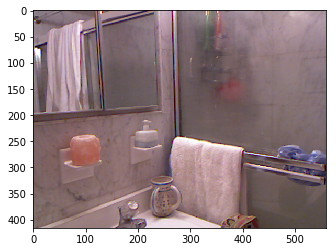

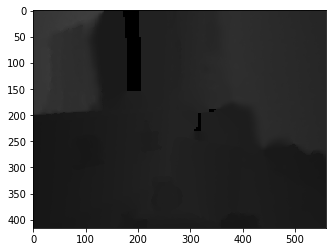

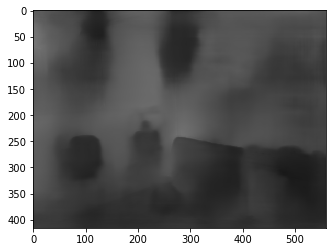

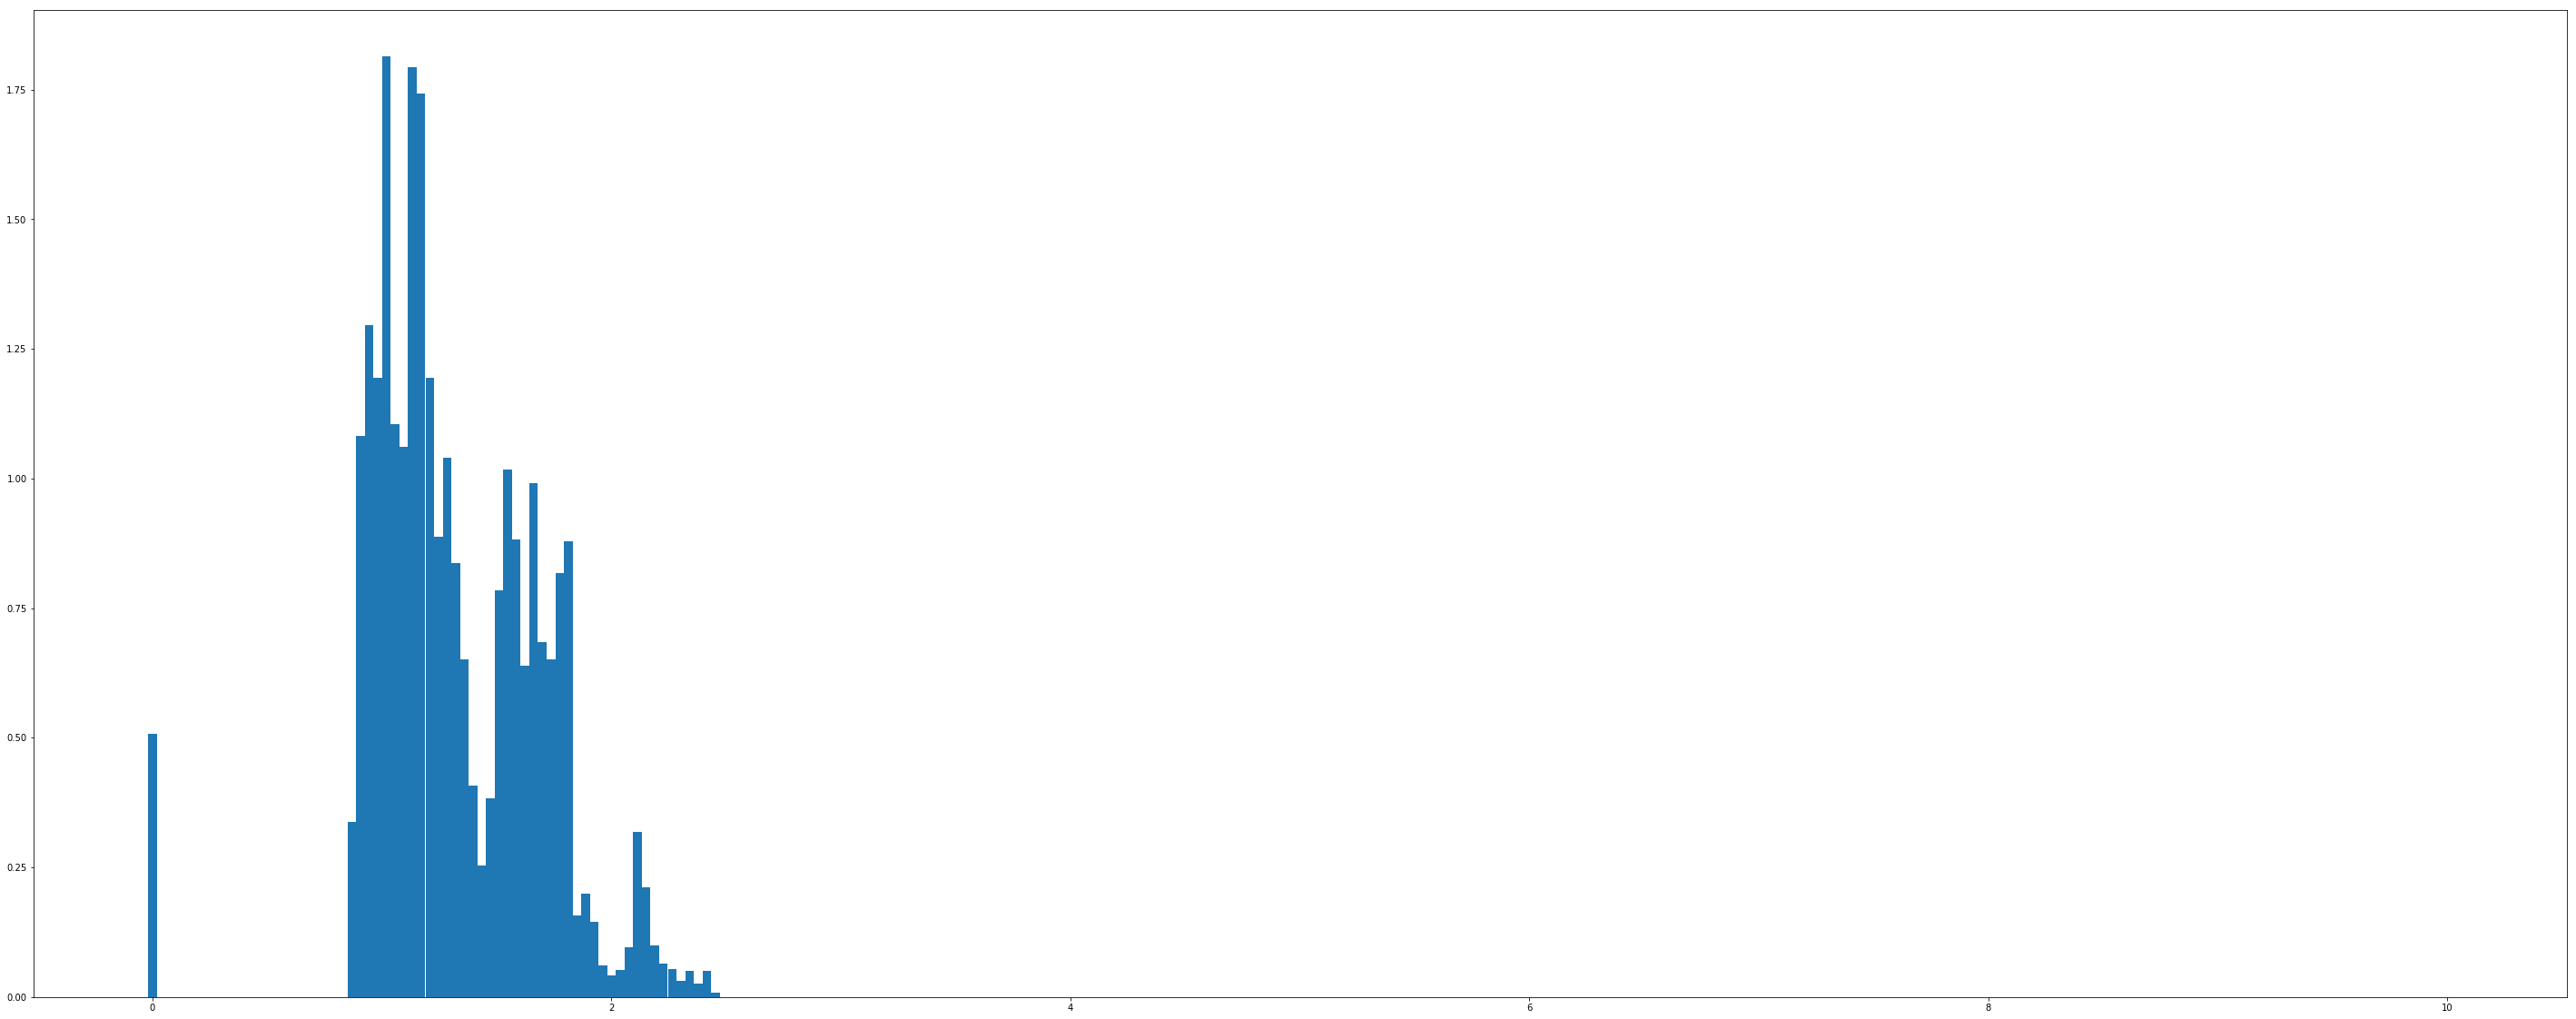

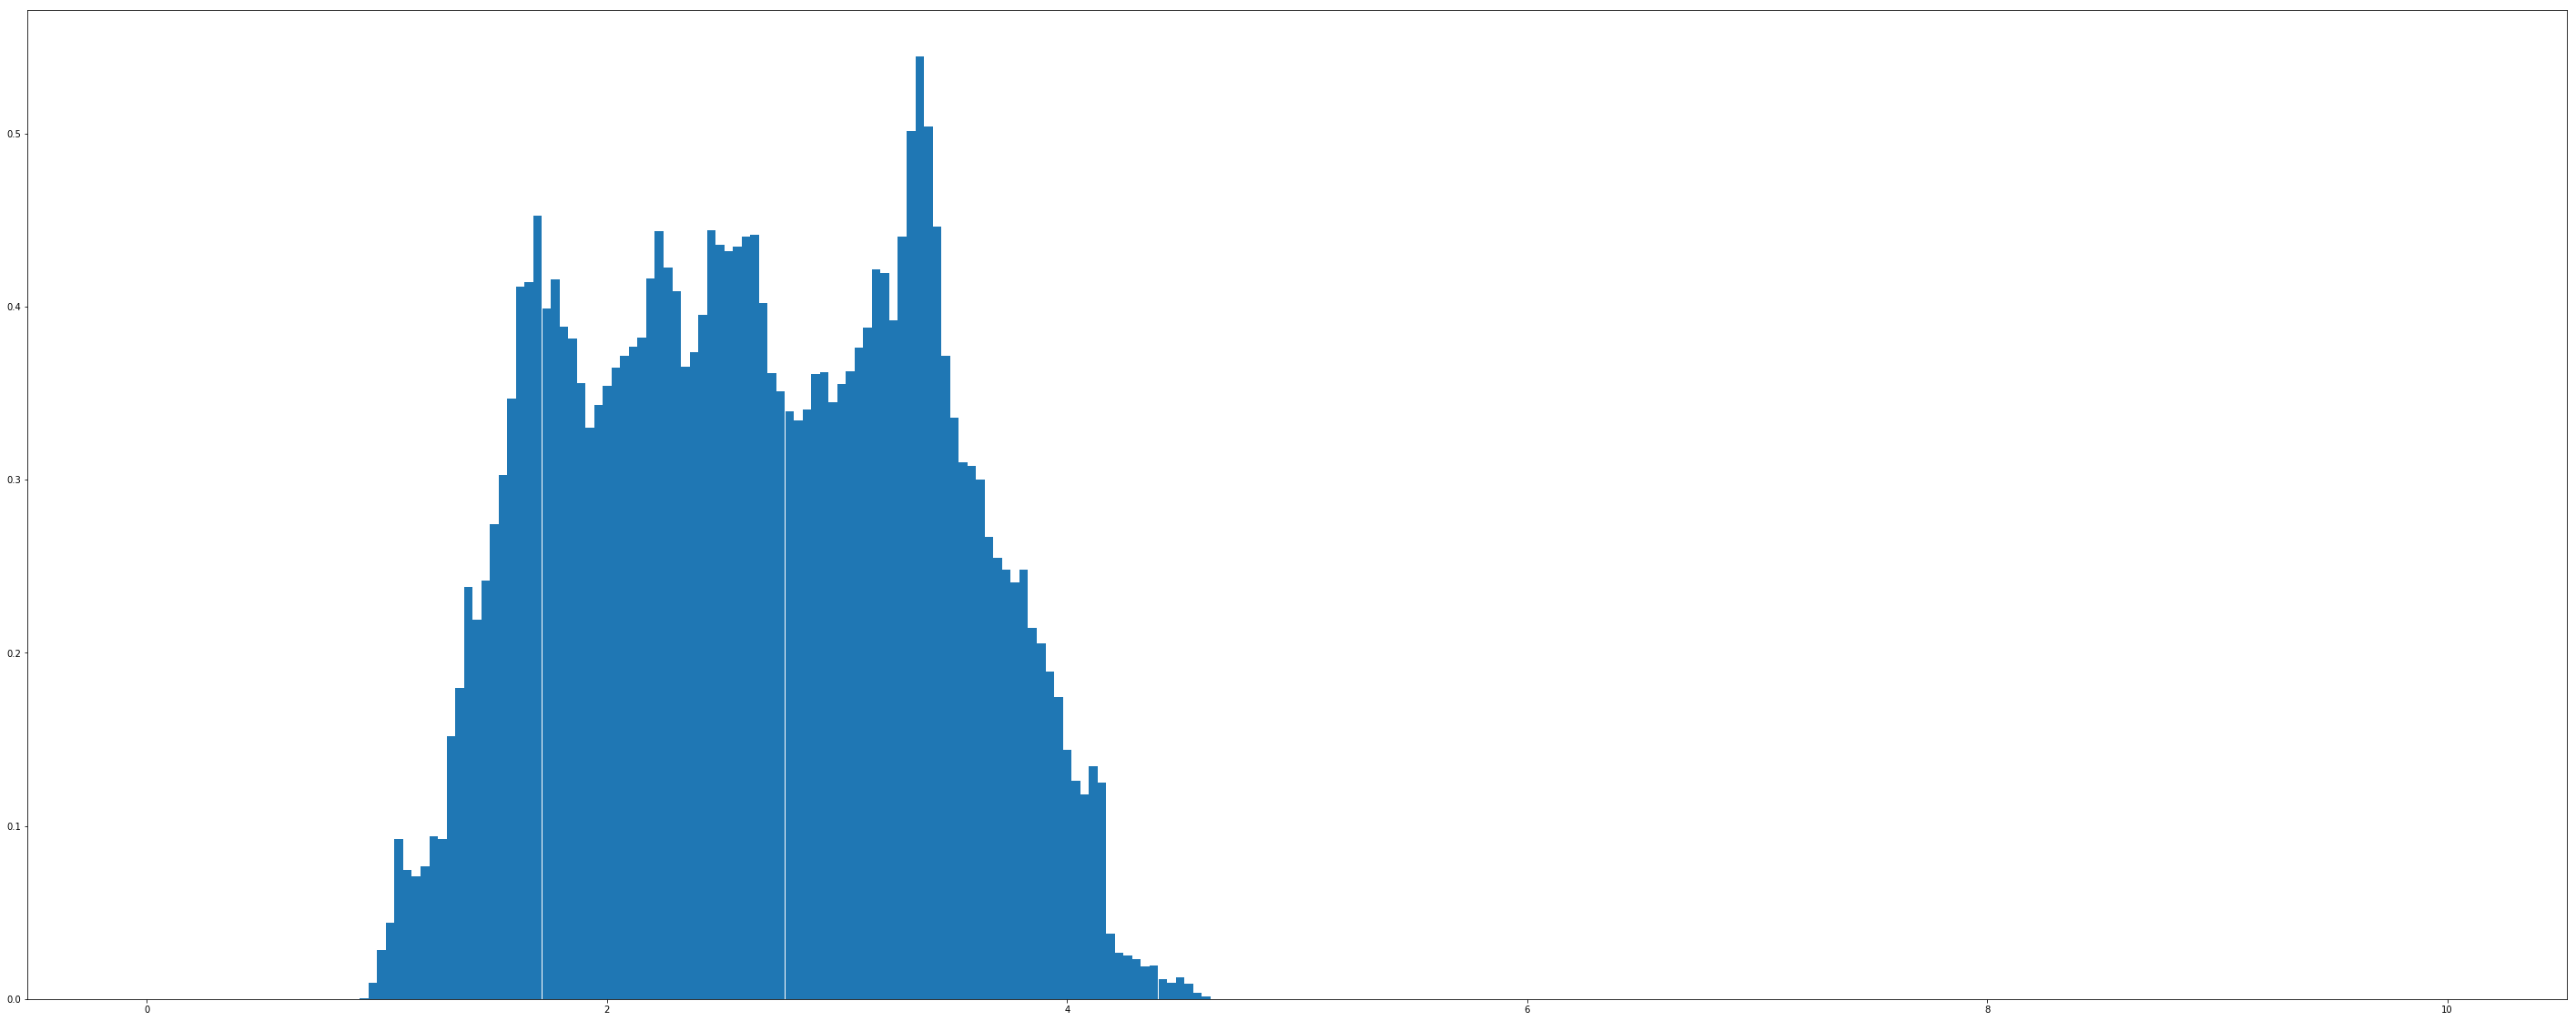

In [11]:
i = 0
data = dataset[i]
sample = outputs[i]
print(sample["depth"].shape)
show(data["rgb"].int()) # RGB image
show((data["depth"]-min_depth)/(max_depth - min_depth)) # ground truth depth
show((sample["depth"].squeeze(0)-min_depth)/(max_depth - min_depth)) # predicted depth
show_hist(data["hist"].squeeze().cpu().numpy(), min_depth, max_depth)
show_hist(sample["hist"], min_depth, max_depth)

In [41]:
a = torch.tensor([[0, 2, 1],[2, 2, 1], [1, 0, 0]]).long()
b = torch.tensor([0.1, 1, 10])

In [42]:
torch.take(b, a)

tensor([[ 0.1000, 10.0000,  1.0000],
        [10.0000, 10.0000,  1.0000],
        [ 1.0000,  0.1000,  0.1000]])